In [58]:
import torch 
import torchvision

import torch.nn as nn
from torchvision import transforms, models

import os
import matplotlib.pyplot as plt
from PIL import Image
import random
from IPython.display import clear_output

In [59]:
# PATHS
DATA_PATH = os.path.join(os.getcwd(),"data")
INPUT_DATA_PATH = os.path.join(DATA_PATH,"input")
OUTPUT_DATA_PATH = os.path.join(DATA_PATH,"output")
MODELS_PATH = os.environ.get("MODEL_PATH")

os.makedirs(INPUT_DATA_PATH,exist_ok=True)
os.makedirs(OUTPUT_DATA_PATH,exist_ok=True)

IMAGENET_MEAN=torch.tensor([0.485, 0.456, 0.406])
IMAGENET_STD=torch.tensor([0.229, 0.224, 0.225])

device = "cuda" if torch.cuda.is_available() else "cpu"


In [60]:
os.environ['TORCH_HOME'] = MODELS_PATH
model = models.vgg16().features.eval()
model = model.to(device)
for layer in model.parameters():
    layer.requires_grad_(requires_grad=False)

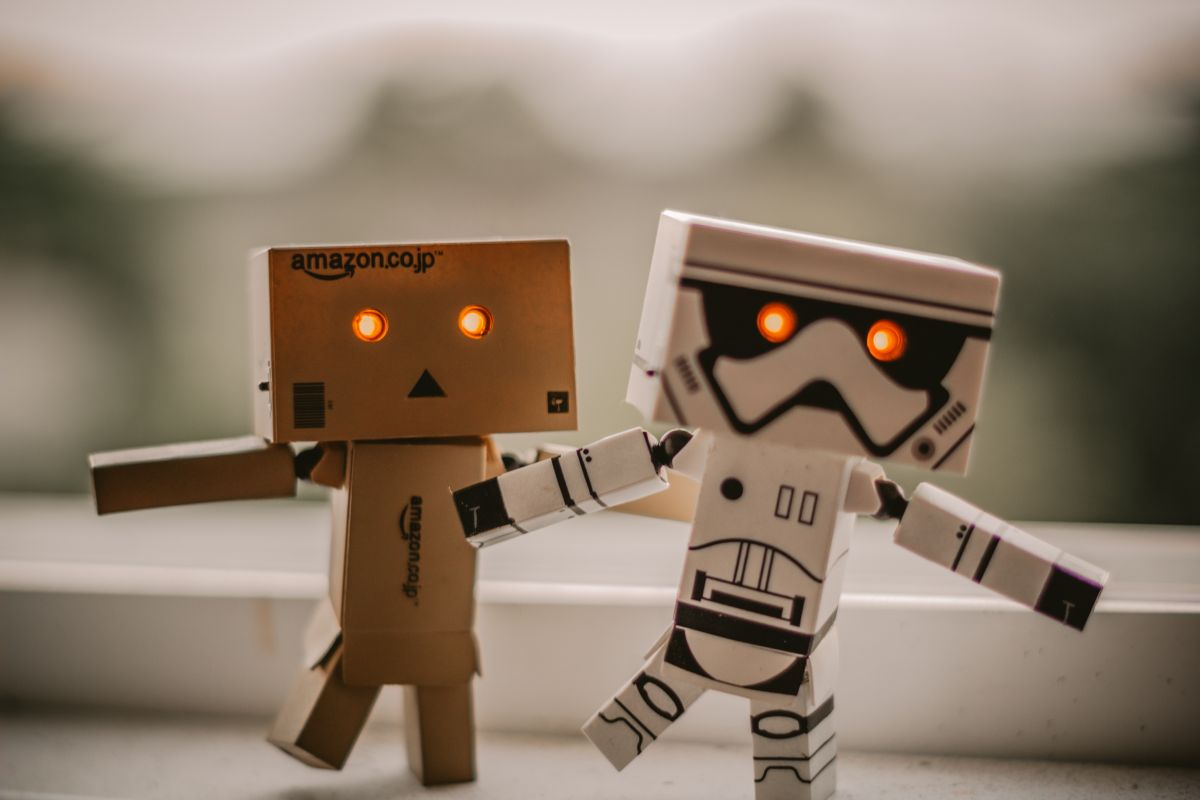

In [61]:
image_path= INPUT_DATA_PATH+"/logo.jpeg"
Image.open(image_path).convert('RGB')

In [62]:
def preprocess_image(image_path):   
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((600, 600)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])
    return transform(image)

image = preprocess_image(image_path)

In [63]:
def deprocess(tensor):
    tensor = tensor.squeeze().detach().cpu()
    tensor = tensor * IMAGENET_STD.view(3, 1, 1)
    tensor = tensor + IMAGENET_MEAN.view(3, 1, 1)
    tensor = tensor.clamp(0., 1.)
    return transforms.ToPILImage()(tensor)

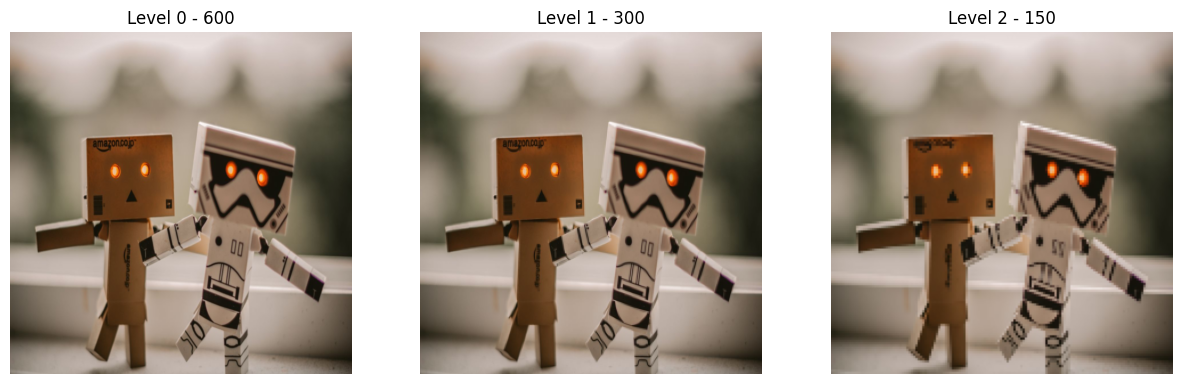

In [64]:
def create_image_pyramid(image, num_levels=5):
    image = image.unsqueeze(0)
    pyramid = [image]
    for i in range(1, num_levels):
        scaled_image = torch.nn.functional.interpolate(
            image, scale_factor=1/(2**i), mode='bilinear', align_corners=False
        )
        pyramid.append(scaled_image)
    return pyramid

def d_normalize(image,mean= IMAGENET_MEAN, std= IMAGENET_STD):
    return image * std.view(3,1,1) + mean.view(3,1,1)

# Display the image pyramid
def show_image_pyramid(pyramid):
    num_levels = len(pyramid)
    fig, axes = plt.subplots(1, num_levels, figsize=(15, 5))
    
    for i, img in enumerate(pyramid):
        img = d_normalize(img).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()  # Convert tensor to image
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Level {i} - {img.shape[-2]}')
    
    plt.show()


images = create_image_pyramid(image,num_levels=3)
show_image_pyramid(images)

In [65]:


def forward_pass(image, model, selected_layer_idx): 
    losses = []
    activations = []
    x = image
    
    for idx, layer in enumerate(model):
        x = layer(x)  # Pass the image through each layer
        if idx in selected_layer_idx:
            activations.append(x)  # Collect activations from selected layers

    for act in activations:
        # Compute loss based on activations
        loss = nn.MSELoss(reduction="mean")(act, torch.zeros_like(act))
        losses.append(loss)

    # Return the average of the losses
    return torch.mean(torch.stack(losses)) if losses else torch.tensor(0.0, requires_grad=True)

def deepdream(model, image, steps, selected_layer_idx,iteration, lr=0.3, device="cuda"):

    # Make sure image requires gradient
    image = image.requires_grad_()

    for step in range(steps):
        # Zero gradients from the previous iteration
        if image.grad is not None:
            image.grad.zero_()

        # Forward pass and compute the loss
        loss = forward_pass(image, model, selected_layer_idx)
        loss.backward()  # Perform gradient ascent

        # Get gradients
        grad = image.grad.data
        smooth_grad = transforms.functional.gaussian_blur(
            grad, kernel_size=random.choice([5, 7, 9, 11]), sigma=random.random() + 0.5
        )
        
        # Normalize the gradients
        g_std = torch.std(smooth_grad)
        g_mean = torch.mean(smooth_grad)
        smooth_grad = (smooth_grad - g_mean) / (g_std + 1e-8)  # Prevent division by zero

        # Update the image by performing gradient ascent
        with torch.no_grad():
            image.data += lr * smooth_grad
            image.data = torch.clamp(image,(-IMAGENET_MEAN/IMAGENET_STD).reshape(1, -1, 1, 1).to(device),((1-IMAGENET_MEAN)/IMAGENET_STD).reshape(1, -1, 1, 1).to(device))

        # Print loss every 100 steps
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.item()}")

    return deprocess(image)

# Parameters
lr = 0.09
steps = 1000
# selected_layer_idx = [ 25, 27, 29,30]
selected_layer_idx = [22]



In [68]:


bucket = []
for iteration,image in enumerate(images[::-1]):
    clear_output(True)
    image = image.to(device).requires_grad_()
    dream_image = deepdream(model, image, steps, selected_layer_idx,iteration, lr=lr)
    bucket.append(dream_image)
    image = image.detach()


Step 0, Loss: 0.016433484852313995
Step 100, Loss: 0.2137623131275177
Step 200, Loss: 0.24538004398345947
Step 300, Loss: 0.2547990679740906
Step 400, Loss: 0.26478078961372375
Step 500, Loss: 0.2702316343784332
Step 600, Loss: 0.27791106700897217
Step 700, Loss: 0.2783745229244232
Step 800, Loss: 0.28178805112838745
Step 900, Loss: 0.2853628098964691


In [74]:
deprocess(bucket[0])

AttributeError: 'Image' object has no attribute 'squeeze'